In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from itertools import islice, cycle
import warnings

# Import clustering methods
from sklearn.cluster import AffinityPropagation, SpectralClustering, KMeans
from sklearn.mixture import GaussianMixture
from hdbscan import HDBSCAN

from umap.umap_ import nearest_neighbors
# from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

import numpy as np

import pickle


/home/marcjb/anaconda3/envs/player_analysis/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [65]:
transfrm_data = pickle.load( open('../models/data/umap_data.p', "rb") )
umap_data = pickle.load( open('../models/data/umap_data.p', "rb") )
pca_data = pickle.load( open('../models/data/pca_data.p', "rb") )

In [66]:
column_names = transfrm_data[0]
pl_data = transfrm_data[1]

In [40]:
umap_data

array([[ 5.8809276 ,  3.6384115 ],
       [ 6.474172  ,  4.365604  ],
       [11.097709  ,  4.8832526 ],
       ...,
       [ 1.0301799 ,  0.966628  ],
       [ 0.62391186,  3.9667256 ],
       [ 0.8910568 ,  3.054428  ]], dtype=float32)

Try different clustering methods: KNN, Affinity Propagation, Gaussian Mixture. 

From the UMAP plot, we sort of know there's going to be between 10-15 clusters, so let's see which makes most sense

Below borrowed heavily from [here](https://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_comparison.html), and [here](https://hdbscan.readthedocs.io/en/latest/advanced_hdbscan.html)

In [67]:

def find_optimal_clusters(clust_start, clust_end, times_to_loop, make_clust_plots=False ):
    ''' Script to explore effect of using different clusters
    Paramters:
        - times_to_loop: if we want to look at average effects, this will cluster given number of times and find average of scores. '''
    # cluster params
    orig_params = {
        "damping": 0.9,
        "preference": -200,
        "min_samples": 10, 
        "random_state": 42
    }

    # Initialize clustering algorithms     
    kmean = KMeans(
        )
        
    spectral = SpectralClustering(
        eigen_solver="arpack",
        affinity="nearest_neighbors"
    )
    affinity_propagation = AffinityPropagation(
        damping= orig_params["damping"], preference=orig_params["preference"]
    )

    hdb_labels = HDBSCAN(
        min_samples=orig_params['min_samples'],
        min_cluster_size=20
    )

    gmm = GaussianMixture(
    covariance_type="full"
    )

    clustering_algorithms = (
    ("KMeans", kmean),
    ("Spectral Clustering", spectral),
    ("Affinity Propagation", affinity_propagation),
    ("HDBSCAN", hdb_labels),
    ("Gaussian Mixture", gmm)
    )


    all_sil_scores = []
    all_db_scores = []
    all_ch_scores = []
    names = []
    cluster_range = range(clust_start,clust_end)
    for name, algorithm in clustering_algorithms:
        algorithm_best_scores = np.zeros(6) # Initialize scoring array
        algorithm_best_scores[2] = 10 # Since we want low scores for this one

        # Keep track of scores
        sil_scores = []
        db_scores = []
        ch_scores = []
        names.append(name)
        if make_clust_plots:
            plt.figure(figsize=(9 * 2 + 3, 13))
        plot_num = 1
        
        for num_clust in cluster_range:
            sil_avgs = []
            db_avgs = []
            ch_avgs = []
            for sim_num in range(times_to_loop):
                # catch warnings related to kneighbors_graph
                with warnings.catch_warnings():
                    warnings.filterwarnings(
                        "ignore",
                        message="Graph is not fully connected, spectral embedding"
                        + " may not work as expected.",
                        category=UserWarning,
                    )

                n_clusters = {f"n_clusters": num_clust}
                n_comp = {f"n_components": num_clust}
                
                # Affinity propagation doesn't like you to identify clusters...
                if ( (name == "KMeans") | (name == "Spectral Clustering")):
                    algorithm.set_params(**n_clusters)
                elif ( (name == "Gaussian Mixture")):
                    algorithm.set_params(**n_comp)

                clusters = algorithm.fit_predict(umap_data)

                
                silhouette_avg = silhouette_score(umap_data, clusters)
                db_score = davies_bouldin_score(umap_data, clusters)
                ch_score = calinski_harabasz_score(umap_data, clusters)

                # Find and save best scores and cluster they belong to
                if silhouette_avg > algorithm_best_scores[0]:
                    algorithm_best_scores[0] = silhouette_avg
                    algorithm_best_scores[1] = int(num_clust)
                if db_score < algorithm_best_scores[2]:
                    algorithm_best_scores[2] = db_score 
                    algorithm_best_scores[3] = int(num_clust) 
                if ch_score > algorithm_best_scores[4]:
                    algorithm_best_scores[4] = ch_score 
                    algorithm_best_scores[5] = int(num_clust )


                ### Might work for HDBSCAN<?
                # color_palette = sns.color_palette('deep', 8)
                # cluster_colors = [color_palette[x] if x >= 0
                #           else (0.5, 0.5, 0.5)
                #           for x in clusterer.labels_]
                # cluster_member_colors = [sns.desaturate(x, p) for x, p in
                #                  zip(cluster_colors, clusterer.probabilities_)]
                # plt.scatter(*data.T, s=50, linewidth=0, c=cluster_member_colors, alpha=0.25)
                if make_clust_plots:
                    colors = np.array(
                    list(
                        islice(
                            cycle(
                                [
                                    "#FF3333",
                                    "#ff9933",
                                    "#32d927",
                                    "#35e8b2",
                                    "#35d2e8",
                                    "#2237e8",
                                    "#ffff33",
                                    "#9915e9",
                                    "#984ea3",
                                    "#e43582",
                                    "#ff5b5d",
                                    "#717480",
                                    "#ea36e6",
                                    "#66866d",
                                    "#99ffcc",
                                    "#ff66ff",
                                    "#404040",
                                ]
                                ),
                            int(max(clusters) + 1),
                            )
                        )
                    )
                    # add black color for outliers (if any)
                    colors = np.append(colors, ["#000000"])
                    plt.subplot(len(clustering_algorithms), len(cluster_range), plot_num)
                    plt.scatter(umap_data[:, 0], umap_data[:, 1], s=10, color=colors[clusters])

                    plt.title(f"{name}\n{num_clust} clusters")
                    plt.xlim(-3.5, 13.0)
                    plt.ylim(2.5, 10.5)
                    plt.xticks(())
                    plt.yticks(())
                    plt.xlabel(f"Silhouette ={silhouette_avg:.2f}\nDavies-Bouldin = {db_score:.2f}\nCalinski-Harabasz = {ch_score:.2f}")
                    plot_num += 1

                # Affinity propagation, HDBSCAN only need to be done once
                if (name == "Affinity Propagation") | (name == "HDBSCAN"):
                    print(f"{name} has {len(set(algorithm.labels_))} clusters.")
                    # Only one result, but add to list so we can compare other methods in our plot
                    sil_scores += (clust_end-clust_start)*[silhouette_avg]
                    db_scores += (clust_end-clust_start)*[db_score]
                    ch_scores += (clust_end-clust_start)*[ch_score]
                    
                    # Check how many points HDBSCAN actually clusters
                    if (name == "HDBSCAN"): 
                        hdbscan_clustered = np.sum(clusters >=0)/umap_data.shape[0]
                        print(f"{name} clustered {hdbscan_clustered*100:.1f}% of the data.")

                    break

                db_avgs.append(db_score)
                sil_avgs.append(silhouette_avg)
                ch_avgs.append(ch_score)
            if (name == "Affinity Propagation") | (name == "HDBSCAN"):
                break
            # Add scores to list that we'll totally be plotting
            db_scores.append(np.mean(db_avgs))
            sil_scores.append(np.mean(silhouette_avg))
            ch_scores.append(np.mean(ch_score))
            
       
        # These only give one type of cluster, so list results of that clustering
        # if (name == "Affinity Propagation") | (name == "HDBSCAN"):
        #     print(f"For {name}, the best Silhouette score was {algorithm_best_scores[0]}.")
        #     print(f"For {name}, the Davies-Bouldin score was {algorithm_best_scores[2]},")
        #     print(f"For {name}, the best Calinski-Harabasz score was {algorithm_best_scores[4]}.")

        # if (name != "Affinity Propagation") & (name !=  "HDBSCAN"):
        all_sil_scores.append(sil_scores)
        all_db_scores.append(db_scores)
        all_ch_scores.append(ch_scores)
        if make_clust_plots: 
             plt.show()

    n_components = np.arange(clust_start, clust_end)
    plt.plot(n_components, all_sil_scores[0], label=names[0])
    plt.plot(n_components, all_sil_scores[1], label=names[1])
    plt.plot(n_components, all_sil_scores[2], label=names[2])
    plt.plot(n_components, all_sil_scores[3], label=names[3])
    plt.plot(n_components, all_sil_scores[4], label=names[4])
    plt.legend(loc='best')
    plt.title("Silhouette (close to 1 is good)")
    plt.xlabel('n_components')
    plt.show()
    plt.plot(n_components, all_db_scores[0], label=names[0])
    plt.plot(n_components, all_db_scores[1], label=names[1])
    plt.plot(n_components, all_db_scores[2], label=names[2])
    plt.plot(n_components, all_db_scores[3], label=names[3])
    plt.plot(n_components, all_db_scores[4], label=names[4])
    plt.legend(loc='best')
    plt.xlabel('n_components')
    plt.title("Davies-Bouldin (close to 0 is good)")
    plt.show()
    plt.plot(n_components, all_ch_scores[0], label=names[0])
    plt.plot(n_components, all_ch_scores[1], label=names[1])
    plt.plot(n_components, all_ch_scores[2], label=names[2])
    plt.plot(n_components, all_ch_scores[3], label=names[3])
    plt.plot(n_components, all_ch_scores[4], label=names[4])
    plt.legend(loc='best')
    plt.title("Calinsko-Harabasz (higher is better)")
    plt.xlabel('n_components')
    plt.show()

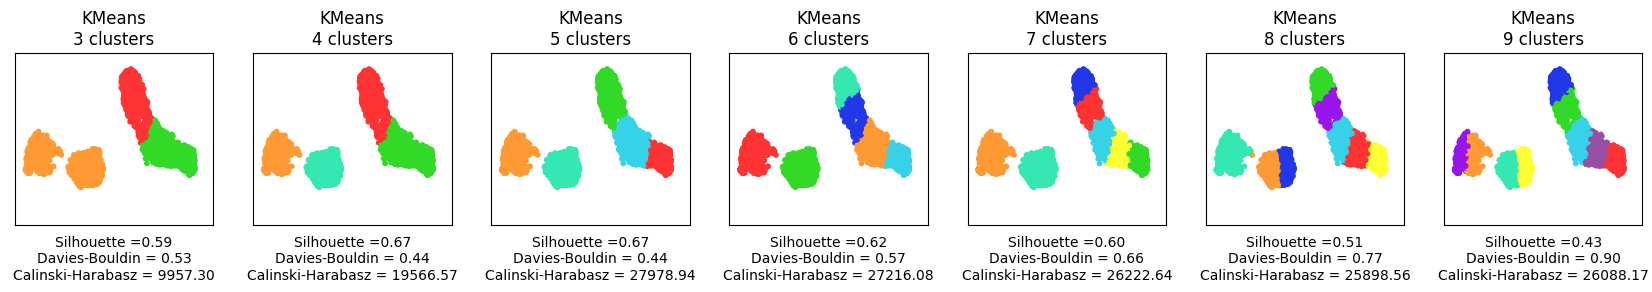

/home/marcjb/anaconda3/envs/player_analysis/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/marcjb/anaconda3/envs/player_analysis/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/marcjb/anaconda3/envs/player_analysis/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/marcjb/anaconda3/envs/player_analysis/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/marcjb/anaconda3/envs/player_analysis/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:

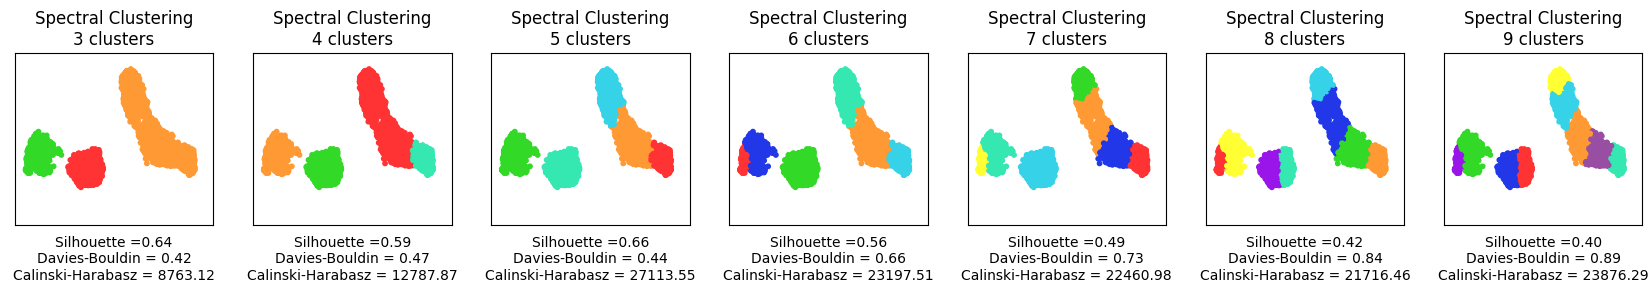

Affinity Propagation has 8 clusters.


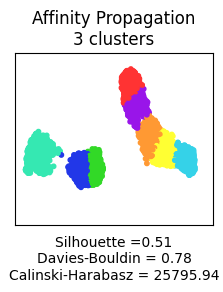

HDBSCAN has 5 clusters.
HDBSCAN clustered 99.1% of the data.


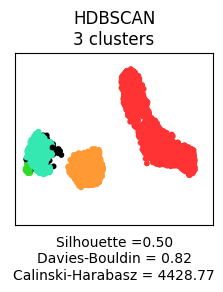

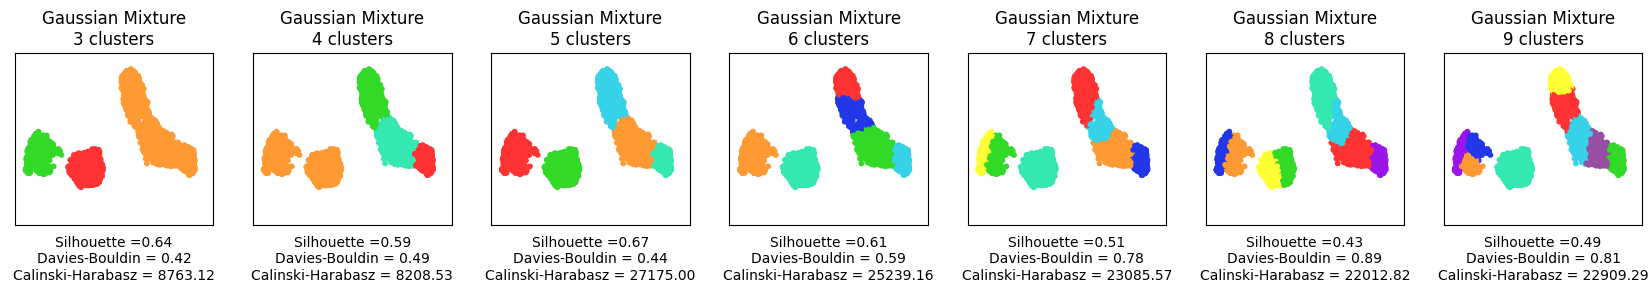

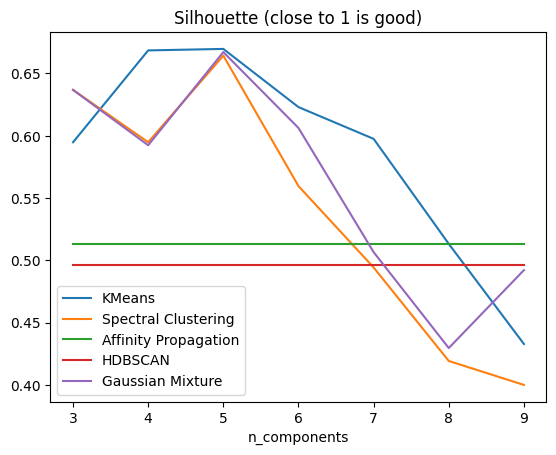

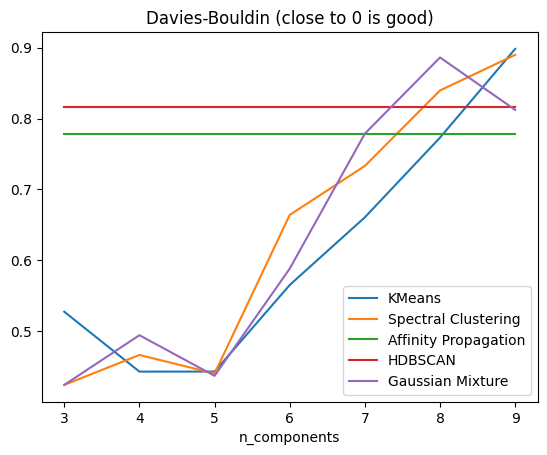

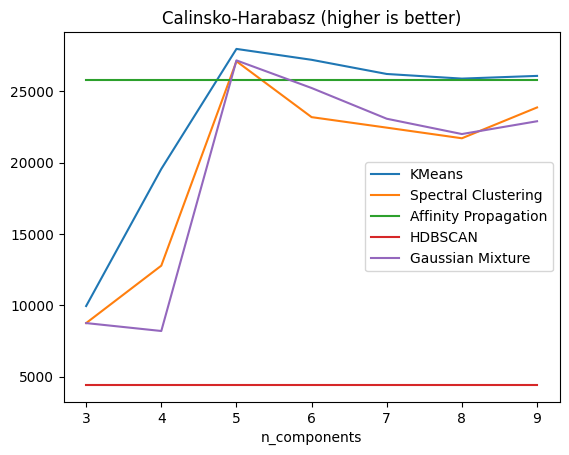

In [68]:
# We can test different numbers here, but it looks like between 9-14 is sweet spot (when we can choose)
# Lots of variety...likely best solution is run a bunch of times, see best results on average
find_optimal_clusters(3, 10, 1, make_clust_plots=True)

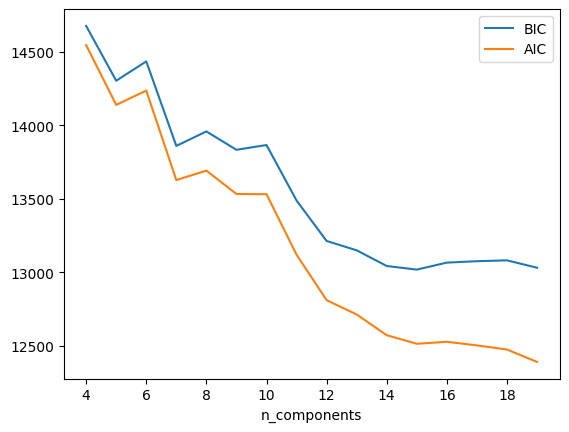

In [12]:
# If we use Spetral clust with 12 clusters? 
n_components = np.arange(4, 20)
models = [GaussianMixture(n, covariance_type='full', random_state=0).fit(umap_data) for n in n_components]
plt.plot(n_components, [m.bic(umap_data) for m in models], label='BIC')
plt.plot(n_components, [m.aic(umap_data) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components')
plt.show()

BIC starts to elbow around 14, so stick with 14 clusters, Gaussian mixture. Have to figure out what they mean though.

Need to be able to match player names to clusters and actually figure out what they do

In [69]:
# Finalize model
spectral = SpectralClustering(
        eigen_solver="arpack",
        affinity="nearest_neighbors",
        n_clusters=5,
        random_state = 42
    )

clusters = spectral.fit_predict(umap_data)
pickle.dump(clusters, open('../models/clusters/spectral_cluster.p', "wb") )

/home/marcjb/anaconda3/envs/player_analysis/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


In [22]:
print(len(clusters))

2167


# Make plot of clusters

In [70]:
# Find number of elements in each cluster
num_unique_clusters, counts = np.unique(clusters, return_counts=True)

dict(zip(num_unique_clusters, (counts/len(clusters))*100))

{0: 21.22425629290618,
 1: 20.394736842105264,
 2: 21.596109839816936,
 3: 13.501144164759726,
 4: 23.283752860411898}

To understand what clusters means, do the following:
- Find players who are at centre of clusters (mean?)
- Look at their percentile rank for each stat
- Identify role based on that
- Calculate similarity to nearest neighbor player (need metric for that)

#### Figure out what the clusters are

Find which players belong to which clusters, then groupby the percentile ranks of those players, see what they're good and not so good at

In [72]:
data = pd.read_csv("../data/processed/sb_individual.csv")

In [23]:
data

,Unnamed: 0,Player,League,Nation,Pos,Squad,Born,90s,Gls/90,Sh/90,...,xG+/-,onG-xG,onGA-xGA,G-xG+/-,Fls,Fld,TimesOffside,Recov,DuelWin%,AerialDuels
0,1,Marcos Acuña,La-Liga,ARG,DF,Sevilla,1991.0,0.660526,0.039841,0.64,...,3.538462,-0.789884,1.126921,0.413408,3.728927,3.219445,0.000000,6.892430,0.407,2.151394
1,2,Martin Agirregabiria,La-Liga,ESP,DF,Alavés,1996.0,0.473684,0.000000,0.22,...,1.032258,1.086909,6.861111,0.613208,2.298851,2.910053,0.055556,4.388889,0.534,3.222222
2,5,Joseph Aidoo,La-Liga,GHA,DF,Celta Vigo,1995.0,0.771053,0.000000,0.20,...,-0.000000,0.560834,1.080774,1.392857,0.761824,1.112925,0.034130,5.597270,0.569,3.720137
3,6,Carlos Akapo,La-Liga,EQG,DF,Cádiz,1993.0,0.539474,0.000000,0.49,...,0.846154,1.541657,0.417073,1.229508,1.911331,2.952814,0.097561,5.463415,0.536,3.365854
4,9,David Alaba,La-Liga,AUT,DF,Real Madrid,1992.0,0.773684,0.068027,0.72,...,1.111111,-0.470006,0.601171,0.415301,1.357151,0.340704,0.068027,4.795918,0.389,1.224490
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3499,5681,Yoshimar Yotún,Liga-MX,PER,MF,Cruz Azul,1990.0,0.226471,0.000000,0.78,...,9.000000,2.523191,2.330447,0.551724,4.847804,2.380512,0.000000,6.363636,0.429,0.909091
3500,5684,Ángel Zaldívar,Liga-MX,MEX,FW,Guadalajara,1994.0,0.520588,0.395480,2.71,...,1.600000,2.195319,3.841808,-1.142857,5.487584,2.788709,0.169492,2.090395,0.302,7.118644
3501,5685,Edgar Zaldívar,Liga-MX,MEX,MF,Atlas,1996.0,0.497059,0.059172,0.59,...,1.750000,-1.083295,0.876953,0.256944,4.383081,2.072157,0.059172,4.970414,0.442,3.076923
3502,5692,Alejandro Zendejas,Liga-MX,MEX,FW,América,1998.0,0.270588,0.434783,1.73,...,1.962963,3.079710,1.971014,2.333333,1.774623,4.901961,0.108696,4.456522,0.438,1.739130


In [103]:
# Add identified cluster to umap coordinates
cluster_list = []
for element in range(len(umap_data)):
    clust = np.append(umap_data[element], clusters[element]+1)
    cluster_list.append(clust)
    cluster_data = pd.DataFrame(cluster_list, columns = ["Component 1", "Component 2", "Cluster"]) # Make a dataframe so we can group by cluster

In [104]:
cluster_data

,Component 1,Component 2,Cluster
0,2.832492,4.733102,1.0
1,2.484792,4.487662,1.0
2,-1.495275,5.557120,3.0
3,2.146683,4.876483,1.0
4,0.261259,5.933138,3.0
...,...,...,...
3491,6.015746,7.748262,2.0
3492,10.754439,5.489940,4.0
3493,6.648802,8.842899,2.0
3494,7.825274,6.299620,5.0


In [105]:
# Change cluster names (for visualization purposes)
cluster_data['Cluster'] = cluster_data['Cluster'].map({4.0:1.0, 5.0:2.0, 2.0:3.0, 1.0:4.0, 3.0:5.0 })

In [106]:
cluster_data

,Component 1,Component 2,Cluster
0,2.832492,4.733102,4.0
1,2.484792,4.487662,4.0
2,-1.495275,5.557120,5.0
3,2.146683,4.876483,4.0
4,0.261259,5.933138,5.0
...,...,...,...
3491,6.015746,7.748262,3.0
3492,10.754439,5.489940,1.0
3493,6.648802,8.842899,3.0
3494,7.825274,6.299620,2.0


In [110]:
print(type(clusters))

<class 'numpy.ndarray'>


In [107]:

cluster_pctl = data.iloc[:, 8:].rank(pct=True)
cluster_pctl["Player Type"] = clusters 
# Drop stats that didn't contribute (mainly goal/assist stats)
cluster_pctl.drop(columns = ['Gls/90', 'np:G-xG', 'Ast', 'xAG', 'A-xAG', 'Sh/90', 'Past', 'Starts', 'Mn/Start',
          'xA', 'onG', 'onGA', '+/-', 'TimesOffside', 
           'On-Off', 'onxG', 'onxGA', 'xG+/-', 'onG-xG', 'onGA-xGA', 'G-xG+/-'], inplace=True)

In [108]:

cluster_avg = cluster_pctl.groupby("Player Type").mean()
player_idx = []

In [76]:
# For each cluster, find areas where they are good, and not so good
all_skills = []
for index, row in cluster_avg.iterrows():
        cluster_skills = []
        cluster_best_skills = row.loc[lambda x: x > 0.7]
        cluster_skills.append(cluster_best_skills)
        cluster_worst_skills = row.loc[lambda x: x < 0.3]## (need to find )]
        cluster_skills.append(cluster_worst_skills)

        all_skills.append(cluster_skills) # All skills contains both best and worst skills


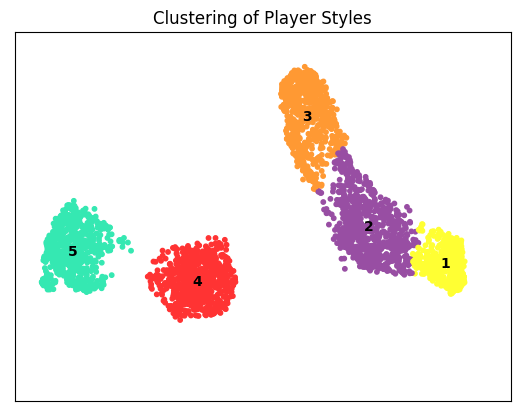

In [98]:
colors = np.array(
list(
    islice(
        cycle(
            [
                "#FF3333",
                "#ff9933",
                "#35e8b2",
                "#ffff33",
                "#984ea3",
                "#2237e8",
                "#32d927",
                "#35d2e8",
                "#9915e9",
                "#e43582",
                "#ff5b5d",
                "#ea36e6",
                "#717480",
                "#66866d",
                "#99ffcc",
                "#ff66ff",
                "#404040",
            ]
            ),
        int(max(clusters) + 1),
        )
    )
)
# add black color for outliers (if any)
colors = np.append(colors, ["#000000"])
# plt.subplot(len(clustering_algorithms), len(cluster_range), plot_num)
plt.scatter(cluster_data.iloc[:, 0], cluster_data.iloc[:, 1], s=10, color=colors[clusters])

for clust in cluster_data['Cluster'].unique():
    plt.annotate(int(clust), 
                cluster_data.loc[cluster_data['Cluster']==clust,['Component 1','Component 2']].mean(),
                horizontalalignment='center',
                verticalalignment='center',
                size=10, weight='bold',
                color= 'black')
                # backgroundcolor = colors[int(clust)]) 

plt.title("Clustering of Player Styles")
plt.xlim(-3.5, 13.0)
plt.ylim(2.5, 10.5)
plt.xticks(())
plt.yticks(())
plt.savefig("../reports/figures/cluster_map.png", bbox_inches = 'tight')
plt.show()

In [112]:
# We're gonna do this for each cluster then, huh...

# plt.style.use('fivethirtyeight')
# sns.set_palette("bwr")
# sns.set(style="whitegrid", color_codes=True)

# Change this so it displays best 10 and worst 10 for that cluster
def playstyle_plots(cluster_num, data):
    '''Plot some exploratory information on each cluster
    Parametrs:
        cluster_num: number of cluster to consider
        df: dataframe to consider, as dataframe'''
    df = pd.DataFrame(data, index=[cluster_num])
    

    #Get labels of 10 highest and 10 lowest average percentile skills 

    bottom_cols = df.iloc[0,:].sort_values().index[:10]
    top_cols = df.iloc[0,:].sort_values(ascending=False).index[:10]
    all_cols = bottom_cols.append(top_cols)
    all_idx = [df.columns.get_loc(col) for col in all_cols]
    #Colour values using heatmap  
    vals = df.values[0]
    pal = sns.color_palette("rainbow", len(vals))
    # Can use below to rank individual one; if we want same colors for all plots, use above
    rank = vals.argsort().argsort()  # http://stackoverflow.com/a/6266510/1628638
    
    ax = sns.barplot(x=df.columns, y=vals, palette=np.array(pal[::-1])[rank])
    # ax = sns.barplot(x=df.columns, y=vals, palette=pal)
    ax.set_xticks(all_idx)
    ax.set_xticklabels(labels = all_cols,
                        rotation = 90, 
                        horizontalalignment = 'center') # Labels to use
    plt.xticks(fontsize = 8)

    labels = ax.get_xticklabels()
    skill_vals = df.iloc[:, all_idx].values[0]
    #Colour low values red, higher values indigo to match barplot color sceheme
    for label, val in zip(labels, skill_vals):
        if val in skill_vals[:10] :
            label.set_color('r')
        if val in skill_vals[10:]:
            label.set_color('indigo')
    
    # Give manually changed labels; if change has happened, skip over other statements
    change = 0
    if cluster_num == 0:
        cluster_num = 3
        change +=1
    elif (cluster_num == 1) & (change == 0):
        cluster_num = 2
        change +=1
    elif (cluster_num == 2) & (change == 0):
        cluster_num = 4
        change +=1
    elif (cluster_num == 3) & (change == 0):
        cluster_num = 0
        change +=1
    elif (cluster_num == 4) & (change == 0):
        cluster_num = 1
        change +=1
    plt.title(f'Average Percentile Skill Ranks for Cluster {cluster_num+1}')
    plt.savefig(f"../reports/figures/cluster_{cluster_num+1}_action_profile.png", bbox_inches="tight")
    plt.show()

    values = df.values.flatten()
    sns.histplot(values)
    plt.title(f'Histogram of Percentiles for Cluster {cluster_num+1}')
    plt.xlabel("Percentile Rank of Action")
    plt.savefig(f"../reports/figures/cluster_{cluster_num+1}_histogram.png", bbox_inches="tight")
    plt.show()

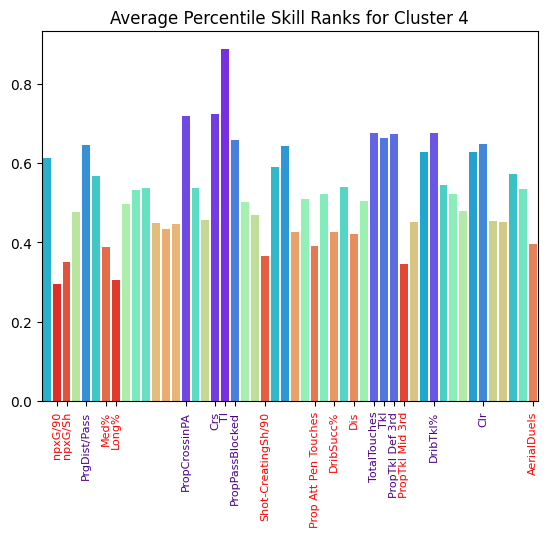

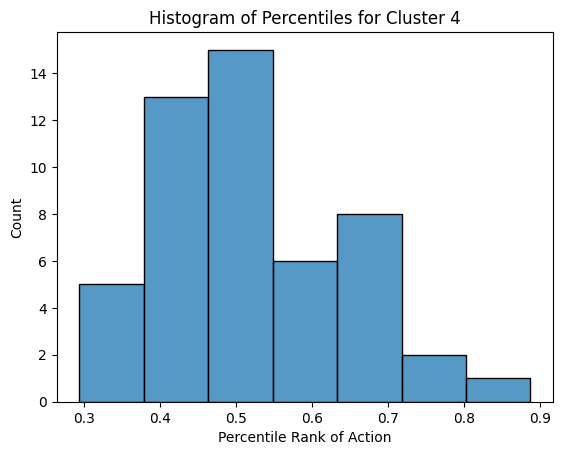

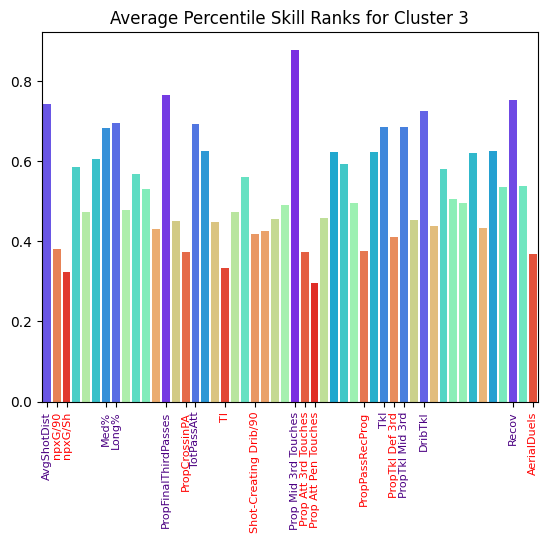

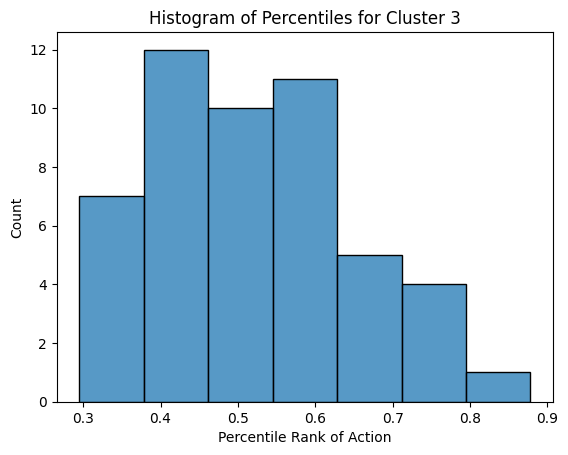

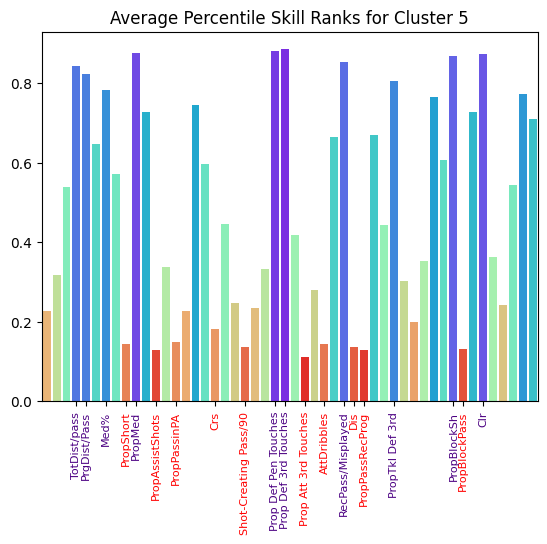

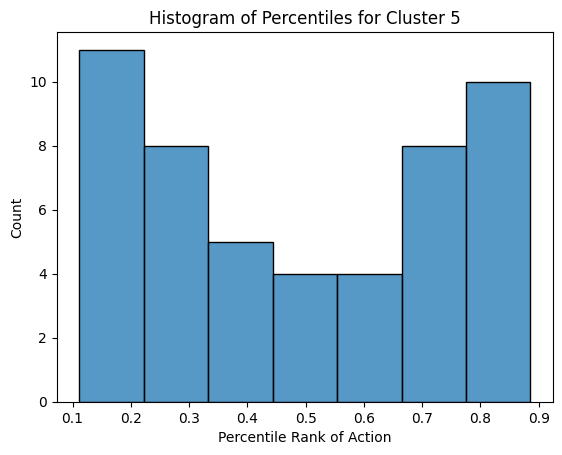

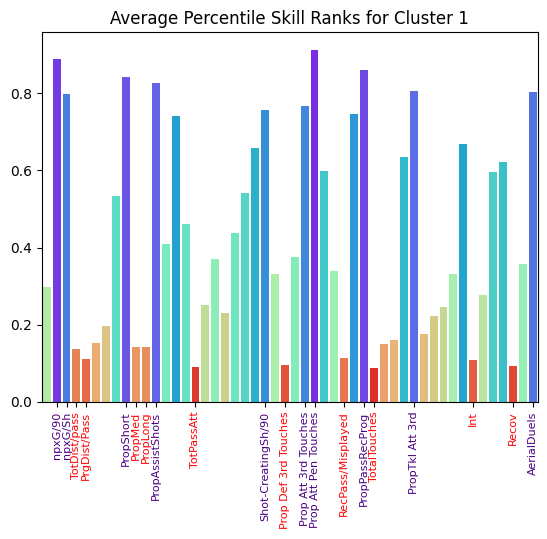

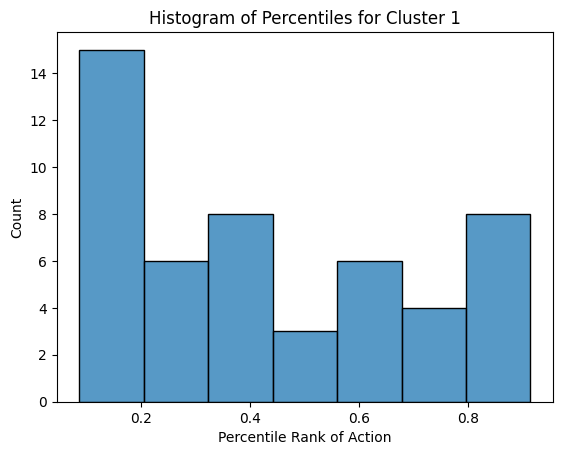

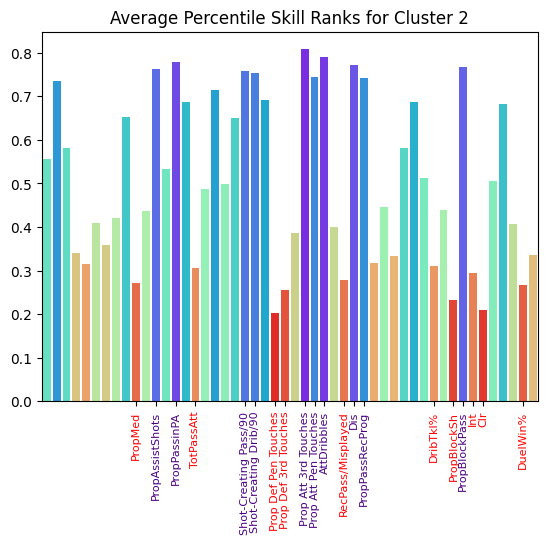

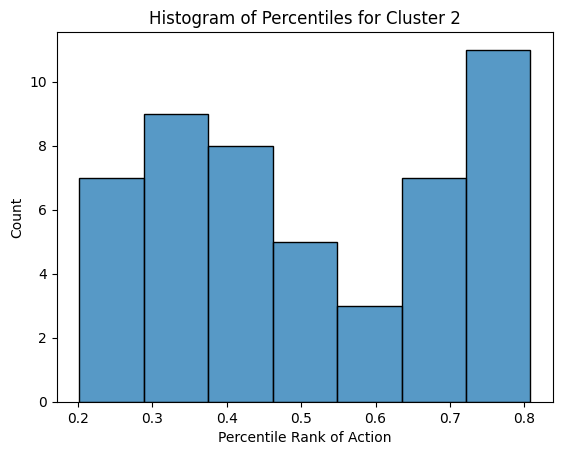

In [113]:
# Need to give correct label
cluster_data['Cluster'] = cluster_data['Cluster'].map({4.0:1.0, 5.0:2.0, 2.0:3.0, 1.0:4.0, 3.0:5.0 })
for cluster_num in set(clusters):
    playstyle_plots(cluster_num, cluster_avg)

# Have way to save this, then just display png

In [405]:
round(data[["onxG", "onxGA" ]],2)


,onxG,onxGA
0,1.09,0.77
1,0.98,1.01
2,1.01,0.95
3,0.95,0.98
4,0.94,0.89
...,...,...
2162,0.97,1.01
2163,1.09,1.10
2164,1.03,1.00
2165,1.10,1.04


#### Creating final dataframe

In [91]:

# First, get df of player data, and add columns we want. 
data = pd.read_csv("../data/processed/sb_individual.csv")
player_data =data[["Player", "League", "Squad", "Pos"]]
player_data["Player Type"] = cluster_data["Cluster"]
player_data[["90s", "Gls/90", "Ast"]] =data[["90s", "Gls/90", "Ast"]]
player_data[["onxG", "onxGA"]] = round(data[["onxG", "onxGA"]],2)



player_data.loc[:,'90s'] = player_data.loc[:,'90s'].apply(lambda x: round(x*100, 1))
player_data.rename(columns = {'90s': 'Minutes\nPlayed (%)'}, inplace=True)

# Get regular goal/assist stats (multiply their per 90 rate by games played, as found above)
player_data.loc[:, "Gls/90"] = player_data["Gls/90"]*(player_data['Minutes\nPlayed (%)']/100) # Gls * games played
player_data.loc[:,"Ast"] = player_data["Ast"]*(player_data['Minutes\nPlayed (%)']/100) # Gls * games played

## Find total goals from per 90 stuff (easier way could be to just get original goal/assist values...but meh)
# MLS, Bundesliga, Eredivisie have 34 games; others have 38 
mask1 = ((player_data['League'] == 'Major-League-Soccer') | (player_data['League'] == 'Bundesliga') | (player_data['League'] == 'Eredivisie')\
    | (player_data['League'] == 'Primeira-Liga') | (player_data['League'] == 'Liga-MX')) 

player_data.loc[mask1, 'Gls/90'] = round(player_data['Gls/90']*34, 0)
player_data.loc[mask1, 'Ast'] = round(player_data['Ast']*34, 0)

# Championship has 40
mask2 = (player_data['League'] == 'Championship')
player_data.loc[mask2, 'Gls/90'] = round(player_data['Gls/90']*40, 0)
player_data.loc[mask2, 'Ast'] = round(player_data['Ast']*40, 0)
# Do it for other leagues
player_data.loc[~(mask1 | mask2), 'Gls/90'] =round( player_data['Gls/90']*38, 0)
player_data.loc[~(mask1 | mask2), 'Ast'] = round(player_data['Ast']*38, 0)

# Rename Leagues
player_data['League'] = player_data['League'].map({'Major-League-Soccer': 'Major League Soccer', 'Bundesliga': 'German Bundesliga',\
    'Serie-A': 'Italian Serie A', 'Eredivisie': 'Dutch Eredivisie', 'Championship': 'English Championship', 'Primeira-Liga': 'Portugese Primeira Liga', \
        'La-Liga': 'Spanish La Liga', 'Liga-MX': 'Liga MX', 'Ligue-1': 'French Ligue-1', 'Premier-League': 'English Premier League'})

#Round values down
player_data[["Minutes\nPlayed (%)"]] = round(player_data[["Minutes\nPlayed (%)"]],2)

player_data.rename(columns={"Gls/90": 'Goals', "Ast": "Assists"}, inplace=True)
player_data = player_data.astype({"Player Type": "int", "Goals": "int", "Assists": "int"})

# player_data.replace("Ma")


player_data.to_csv("../data/processed/display_player_data.csv")

/tmp/ipykernel_18093/2350788736.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data["Player Type"] = cluster_data["Cluster"]
/tmp/ipykernel_18093/2350788736.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data[["90s", "Gls/90", "Ast"]] =data[["90s", "Gls/90", "Ast"]]
/tmp/ipykernel_18093/2350788736.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

In [92]:
# Now, need to see what these roles mean...
# Find UMAP coordinates that are at centre of cluster

cluster_centres = []
for clust in cluster_data['Cluster'].unique():
    ind_clust_cent = np.array(cluster_data.loc[cluster_data['Cluster']==clust,['Component 1','Component 2']].mean())
    cluster_centres.append(ind_clust_cent)
# Append to umap_data
player_avg_clust = list(umap_data) 
player_avg_clust.extend(cluster_centres)

#Find players closest to average of clusters
# Use nearest neighbors to find umap co-ordinates closest to mean for each cluster
player_idx = []
for cluster in num_unique_clusters:
        nn = nearest_neighbors(np.array(player_avg_clust),
                                n_neighbors = 2,
                                metric="euclidean",
                                metric_kwds=None,
                                angular=False,
                                random_state=None
                        )
        idx = len(umap_data)+cluster # Cluster number we're finding
        neighbor_idx = nn[0][idx][1] # Find index of player closest to the centre of that cluster

        player_idx.append(neighbor_idx)

cluster_centres = player_data.iloc[player_idx] # Find players who best represent that cluster
####
# Convert to dictionary for easy accessing
# idx_cluster_dict = dict(idx_cluster)
# Show where player ranks (as percentile) for each statistic and create dataframe with that stuff added.




In [93]:
player_data.iloc[player_idx].sort_values(by=['Player Type']).drop_duplicates()

,Player,League,Squad,Pos,Player Type,Minutes\nPlayed (%),Goals,Assists,onxG,onxGA
3184,Eduardo Aguirre,Liga MX,Santos,FW,1,60.0,4,1,1.05,1.03
2597,Ivan Jaime Pajuelo,Portugese Primeira Liga,Famalicão,MF,2,41.2,1,2,0.98,1.02
2542,Tiago Dantas,Portugese Primeira Liga,Tondela,MF,3,35.9,1,2,1.29,1.35
1059,Simon Asta,German Bundesliga,Greuther Fürth,DF,4,25.6,0,0,0.88,1.02
1898,Robin Jansson,Major League Soccer,Orlando City,DF,5,64.4,1,1,1.08,1.00


In [30]:
# Create neighbors data and see example
neighbors = 11
player_name = 'Robert Lewandowski'

idx = player_data[player_data['Player'] == player_name].index
# Identify players who are most similar to a given player:

neighbors = nearest_neighbors(umap_data,
                            n_neighbors = neighbors,
                            metric="euclidean",
                            metric_kwds=None,
                            angular=False,
                            random_state=None
                    )
# If player has changed leagues or teams, they'll be listed twice. Check for that...
# If more than one index, need to choose one

neighbor_idx = neighbors[0][idx] # Find index of player closest to the centre of that cluster
similar_players = player_data.iloc[neighbor_idx[0], :]
similar_players 


,Player,League,Squad,Pos,Player Type,Minutes Played (%),Goals,Assists,onxG,onxGA
1206,Robert Lewandowski,German Bundesliga,Bayern Munich,FW,6,96.2,35,3,0.99,1.01
1593,Krzysztof Piątek,Italian Serie A,Fiorentina,FW,6,21.3,3,0,0.99,1.04
1545,Lautaro Martínez,Italian Serie A,Inter,FW,6,66.8,21,3,1.07,0.99
289,Ángel Rodríguez,Spanish La Liga,Mallorca,FW,6,45.3,4,2,1.06,1.02
2127,Maximiliano Urruti,Major League Soccer,Austin,FW,6,71.5,9,0,0.99,0.99
1081,Rafael Borré,German Bundesliga,Eint Frankfurt,FW,6,77.6,8,4,1.06,0.98
137,Sergi Guardiola,Spanish La Liga,Rayo Vallecano,FW,6,50.0,8,2,1.02,0.81
1817,Jeremy Ebobisse,Major League Soccer,San Jose,FW,6,96.2,17,2,1.00,0.97
2390,Amin Sarr,Dutch Eredivisie,Heerenveen,FW,6,35.3,5,1,1.08,0.91
3311,Ian Gonzalez Nieto,Liga MX,Toluca,FW,6,49.4,4,0,1.09,0.96


In [31]:
near_neighb = pd.DataFrame(neighbors[0])
near_neighb

near_neighb.to_csv("../data/processed/nearest_neighbors.csv")